In [4]:
# 1: Install Hugging Face Transformers

!pip install transformers sentencepiece

from transformers import pipeline
import random, re


In [5]:
# 2: Load Hugging Face Model

generator = pipeline("text2text-generation", model="google/flan-t5-large")

print("✅ Model loaded successfully")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


✅ Model loaded successfully


In [6]:
# 3: Flashcard Functions

def generate_flashcards(topic, num_cards=5):
    """
    Generate Q&A flashcards for a given topic using a Hugging Face model.
    """
    flashcards = []
    for i in range(num_cards):
        prompt = f"Create a study flashcard on the topic '{topic}'. Format as 'Q: ... A: ...'."
        result = generator(prompt, max_new_tokens=150, do_sample=True, temperature=0.7)
        text = result[0]['generated_text']

        # Try to extract Q/A
        match = re.findall(r"Q:(.*)A:(.*)", text, re.S)
        if match:
            q, a = match[0]
            flashcards.append({
                "question": q.strip(),
                "answer": a.strip()
            })
        else:
            # fallback in case parsing fails
            flashcards.append({
                "question": f"What is {topic}?",
                "answer": f"{topic} is an important concept to study."
            })
    return flashcards

def display_flashcards(flashcards):
    """
    Print flashcards nicely.
    """
    for i, fc in enumerate(flashcards, 1):
        print(f"Flashcard {i}")
        print("Q:", fc["question"])
        print("A:", fc["answer"])
        print("-"*40)


In [7]:
# 4: Generate Flashcards

topic = "Machine Learning Basics"
flashcards = generate_flashcards(topic, num_cards=5)

display_flashcards(flashcards)


Flashcard 1
Q: What is Machine Learning Basics?
A: Machine Learning Basics is an important concept to study.
----------------------------------------
Flashcard 2
Q: What is Machine Learning Basics?
A: Machine Learning Basics is an important concept to study.
----------------------------------------
Flashcard 3
Q: What is Machine Learning Basics?
A: Machine Learning Basics is an important concept to study.
----------------------------------------
Flashcard 4
Q: What is Machine Learning Basics?
A: Machine Learning Basics is an important concept to study.
----------------------------------------
Flashcard 5
Q: What is Machine Learning Basics?
A: Machine Learning Basics is an important concept to study.
----------------------------------------


In [9]:
# 5: Try Another Topic

topic = "Neural Network"
flashcards = generate_flashcards(topic, num_cards=5)
display_flashcards(flashcards)


Flashcard 1
Q: What is Neural Network?
A: Neural Network is an important concept to study.
----------------------------------------
Flashcard 2
Q: What is Neural Network?
A: Neural Network is an important concept to study.
----------------------------------------
Flashcard 3
Q: What is Neural Network?
A: Neural Network is an important concept to study.
----------------------------------------
Flashcard 4
Q: What is Neural Network?
A: Neural Network is an important concept to study.
----------------------------------------
Flashcard 5
Q: What is Neural Network?
A: Neural Network is an important concept to study.
----------------------------------------


In [10]:
# 6: Simple Quiz Helpers

def _normalize_text(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", " ", (s or "").lower()).strip()

def check_free_text(expected: str, user_text: str) -> bool:
    E = _normalize_text(expected)
    U = _normalize_text(user_text)
    if not E or not U:
        return False
    # Loose matching: containment, prefix match, or high token overlap
    if U in E or E in U:
        return True
    e_tokens, u_tokens = E.split(), U.split()
    overlap = len(set(e_tokens) & set(u_tokens)) / max(1, len(set(e_tokens)))
    return overlap >= 0.6

def quiz_one(card: dict, user_answer: str) -> dict:
    t = card.get("type", "qa")
    if t == "mcq":
        # allow A/B/C/D or full option text
        ua = user_answer.strip()
        opts = card.get("options", [])
        correct_text = card.get("answer", "")
        correct_letter = card.get("answer_letter", "")
        letter_map = {chr(65+i): opts[i] for i in range(len(opts))}
        # normalize user input
        ua_norm = ua.strip().upper()
        if ua_norm in letter_map:
            ua_text = letter_map[ua_norm]
        else:
            ua_text = user_answer
        ok = _normalize_text(ua_text) == _normalize_text(correct_text)
        return {
            "correct": ok,
            "expected": f"{correct_letter}. {correct_text}" if correct_letter else correct_text,
            "explanation": card.get("explanation", "")
        }
    elif t == "tf":
        expected = (card.get("answer","True")).strip().lower()
        ua = (user_answer or "").strip().lower()
        ok = ua in ["t","true","f","false"] and ((ua.startswith("t") and expected=="true") or (ua.startswith("f") and expected=="false"))
        return {
            "correct": ok,
            "expected": expected.title(),
            "explanation": card.get("explanation","")
        }
    else:  # qa or others -> free text
        expected = card.get("answer","")
        ok = check_free_text(expected, user_answer)
        return {
            "correct": ok,
            "expected": expected,
            "explanation": card.get("explanation","")
        }

def pretty_print_card(i: int, card: dict):
    print(f"\n--- Card {i} | {card.get('type','qa').upper()} ---")
    print("Q:", card.get("question",""))
    if card.get("type") == "mcq" and card.get("options"):
        for j, opt in enumerate(card["options"]):
            print(f"  {chr(65+j)}. {opt}")


In [11]:
# 7: Exporters (CSV / Anki TSV / JSON)
import os, json

EXPORT_DIR = "flashcards_exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

def export_csv(deck, fname="flashcards.csv"):
    df = pd.DataFrame(deck)
    path = os.path.join(EXPORT_DIR, fname)
    df.to_csv(path, index=False)
    return path

def export_anki_tsv(deck, fname="anki_import.tsv"):
    """
    Minimal Anki format: Front[TAB]Back[TAB]Tags
    For MCQ, we include options in the front for context.
    """
    lines = []
    for c in deck:
        front = c["question"]
        if c.get("type") == "mcq" and c.get("options"):
            opts = "<br>".join([f"{chr(65+i)}. {opt}" for i, opt in enumerate(c["options"])])
            front = f"{front}<br>{opts}"
        back = c.get("answer","")
        if c.get("explanation"):
            back += f"<br><i>{c['explanation']}</i>"
        tags = c.get("type","qa")
        lines.append(f"{front}\t{back}\t{tags}")
    path = os.path.join(EXPORT_DIR, fname)
    with open(path, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))
    return path

def export_json(deck, fname="flashcards.json"):
    path = os.path.join(EXPORT_DIR, fname)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(deck, f, ensure_ascii=False, indent=2)
    return path


In [13]:
try:
    generate_deck
except NameError:
    def generate_deck(topic, n_qa=6, n_mcq=5, n_tf=4):
        deck = []
        deck += generate_qa(topic, n_qa)
        deck += generate_mcq(topic, n_mcq)
        deck += generate_tf(topic, n_tf)
        return deck
    print("✅ generate_deck was missing; defined now.")
else:
    print("✅ generate_deck already defined.")


✅ generate_deck was missing; defined now.


In [17]:
# 8a: Repair Missing Functions
import re, json, os, pandas as pd

# If runtime reset, make sure the HF model exists
try:
    generator
except NameError:
    from transformers import pipeline
    generator = pipeline("text2text-generation", model="google/flan-t5-large")
    print("ℹ️ Model loaded again")

def ensure_fn(name, fn):
    if name not in globals():
        globals()[name] = fn
        print(f"• Defined missing: {name}")

# Re-define generate_deck (in case it’s missing)
def _generate_deck(topic, n_qa=6, n_mcq=5, n_tf=4):
    deck = []
    deck += generate_qa(topic, n_qa)
    deck += generate_mcq(topic, n_mcq)
    deck += generate_tf(topic, n_tf)
    return deck
ensure_fn("generate_deck", _generate_deck)

# Re-define pretty_print_card
def _pretty_print_card(i: int, card: dict):
    print(f"\n--- Card {i} | {card.get('type','qa').upper()} ---")
    print("Q:", card.get("question",""))
    if card.get("type") == "mcq" and card.get("options"):
        for j, opt in enumerate(card["options"]):
            print(f"  {chr(65+j)}. {opt}")
ensure_fn("pretty_print_card", _pretty_print_card)

# Re-define quiz_one
def _normalize_text(s: str) -> str:
    return re.sub(r"[^a-z0-9]+"," ", (s or "").lower()).strip()

def _check_free_text(expected, user_text) -> bool:
    E, U = _normalize_text(expected), _normalize_text(user_text)
    if not E or not U: return False
    if U in E or E in U: return True
    e_tokens, u_tokens = E.split(), U.split()
    overlap = len(set(e_tokens) & set(u_tokens)) / max(1, len(set(e_tokens)) or 1)
    return overlap >= 0.6

def _quiz_one(card: dict, user_answer: str) -> dict:
    t = card.get("type","qa")
    if t == "mcq":
        ua = user_answer.strip()
        opts = card.get("options", [])
        correct_text = card.get("answer","")
        correct_letter = card.get("answer_letter","")
        letter_map = {chr(65+i): opts[i] for i in range(len(opts))}
        ua_text = letter_map.get(ua.upper(), ua)
        ok = _normalize_text(ua_text) == _normalize_text(correct_text)
        return {"correct": ok, "expected": f"{correct_letter}. {correct_text}", "explanation": card.get("explanation","")}
    if t == "tf":
        expected = (card.get("answer","True")).lower()
        ua = (user_answer or "").lower()
        ok = ua.startswith(expected[0])  # first letter match
        return {"correct": ok, "expected": expected.title(), "explanation": card.get("explanation","")}
    # QA fallback
    ok = _check_free_text(card.get("answer",""), user_answer)
    return {"correct": ok, "expected": card.get("answer",""), "explanation": card.get("explanation","")}

ensure_fn("quiz_one", _quiz_one)


In [18]:
# 8b: Generate Deck for Neural Networks
topic2 = "Neural Networks"
deck2 = generate_deck(topic2, n_qa=5, n_mcq=4, n_tf=3)

print(f"✅ Generated {len(deck2)} cards on: {topic2}")

# Show first few flashcards
df2 = pd.DataFrame(deck2)
display(df2.head(10))


✅ Generated 12 cards on: Neural Networks


,type,question,answer,options,answer_letter,explanation
0,qa,What is Neural Networks?,A brief explanation of Neural Networks.,NaN,NaN,NaN
1,qa,What is Neural Networks?,A brief explanation of Neural Networks.,NaN,NaN,NaN
2,qa,What is Neural Networks?,A brief explanation of Neural Networks.,NaN,NaN,NaN
3,qa,What is Neural Networks?,A brief explanation of Neural Networks.,NaN,NaN,NaN
4,qa,What is Neural Networks?,A brief explanation of Neural Networks.,NaN,NaN,NaN
5,mcq,Which option best describes Neural Networks?,A definition,"[A definition, An unrelated term, A dataset, A...",A,Definition matches the concept.
6,mcq,Which option best describes Neural Networks?,A definition,"[A definition, An unrelated term, A dataset, A...",A,Definition matches the concept.
7,mcq,Which option best describes Neural Networks?,A definition,"[A definition, An unrelated term, A dataset, A...",A,Definition matches the concept.
8,mcq,Which option best describes Neural Networks?,A definition,"[A definition, An unrelated term, A dataset, A...",A,Definition matches the concept.
9,tf,Neural Networks is a subfield of data science.,True,NaN,NaN,Generic fallback.


In [19]:
# 8c: Quick Quiz
for idx in range(1, 4):
    card = deck2[idx-1]
    pretty_print_card(idx, card)

    # simulate a guess (you can replace with your own input)
    guess = "A" if card["type"]=="mcq" else ("True" if card["type"]=="tf" else "some guess")
    res = quiz_one(card, guess)

    print("Your answer:", guess)
    print("Correct? ", "✅" if res["correct"] else "❌")
    print("Expected:", res["expected"])
    if res.get("explanation"):
        print("Why:     ", res["explanation"])



--- Card 1 | QA ---
Q: What is Neural Networks?
Your answer: some guess
Correct?  ❌
Expected: A brief explanation of Neural Networks.

--- Card 2 | QA ---
Q: What is Neural Networks?
Your answer: some guess
Correct?  ❌
Expected: A brief explanation of Neural Networks.

--- Card 3 | QA ---
Q: What is Neural Networks?
Your answer: some guess
Correct?  ❌
Expected: A brief explanation of Neural Networks.


In [20]:
# 8d: Export Flashcards
EXPORT_DIR = "flashcards_exports"
os.makedirs(EXPORT_DIR, exist_ok=True)

csv_path  = export_csv(deck2,  "neural_networks_flashcards.csv")
tsv_path  = export_anki_tsv(deck2, "neural_networks_anki.tsv")
json_path = export_json(deck2, "neural_networks_flashcards.json")

print("\n📦 Exported files:")
print("CSV: ", csv_path)
print("TSV: ", tsv_path, " (import into Anki via 'File -> Import')")
print("JSON:", json_path)





📦 Exported files:
CSV:  flashcards_exports/neural_networks_flashcards.csv
TSV:  flashcards_exports/neural_networks_anki.tsv  (import into Anki via 'File -> Import')
JSON: flashcards_exports/neural_networks_flashcards.json


In [21]:
# Cell 9: Any-Topic Runner
# Enter any topic and counts; runs end-to-end.

def run_topic(topic, n_qa=6, n_mcq=5, n_tf=4, export_prefix=None):
    deck = generate_deck(topic, n_qa=n_qa, n_mcq=n_mcq, n_tf=n_tf)
    print(f"✅ Generated {len(deck)} cards on: {topic}")
    df = pd.DataFrame(deck)
    display(df.head(12))

    # Quick quiz preview on first 3
    for idx in range(1, min(4, len(deck))+1):
        card = deck[idx-1]
        pretty_print_card(idx, card)
        guess = "A" if card["type"]=="mcq" else ("True" if card["type"]=="tf" else "some guess")
        res = quiz_one(card, guess)
        print("Your answer:", guess, "|", "✅" if res["correct"] else "❌", "| Expected:", res["expected"])
        if res.get("explanation"):
            print("Why:", res["explanation"])

    # Exports
    prefix = export_prefix or re.sub(r"[^a-z0-9]+","_", topic.lower()).strip("_")
    csv_path  = export_csv(deck,  f"{prefix}.csv")
    tsv_path  = export_anki_tsv(deck, f"{prefix}_anki.tsv")
    json_path = export_json(deck, f"{prefix}.json")
    print("\n📦 Exported files:")
    print("CSV: ", csv_path)
    print("TSV: ", tsv_path, " (import into Anki via 'File -> Import')")
    print("JSON:", json_path)
    return deck, (csv_path, tsv_path, json_path)

_ = run_topic("Support Vector Machines", n_qa=5, n_mcq=4, n_tf=3)


✅ Generated 12 cards on: Support Vector Machines


,type,question,answer,options,answer_letter,explanation
0,qa,What is Support Vector Machines?,A brief explanation of Support Vector Machines.,NaN,NaN,NaN
1,qa,What is Support Vector Machines?,A brief explanation of Support Vector Machines.,NaN,NaN,NaN
2,qa,What is Support Vector Machines?,A brief explanation of Support Vector Machines.,NaN,NaN,NaN
3,qa,What is Support Vector Machines?,A brief explanation of Support Vector Machines.,NaN,NaN,NaN
4,qa,What is Support Vector Machines?,A brief explanation of Support Vector Machines.,NaN,NaN,NaN
5,mcq,Which option best describes Support Vector Mac...,A definition,"[A definition, An unrelated term, A dataset, A...",A,Definition matches the concept.
6,mcq,Which option best describes Support Vector Mac...,A definition,"[A definition, An unrelated term, A dataset, A...",A,Definition matches the concept.
7,mcq,Which option best describes Support Vector Mac...,A definition,"[A definition, An unrelated term, A dataset, A...",A,Definition matches the concept.
8,mcq,Which option best describes Support Vector Mac...,A definition,"[A definition, An unrelated term, A dataset, A...",A,Definition matches the concept.
9,tf,Support Vector Machines is a subfield of data ...,True,NaN,NaN,Generic fallback.



--- Card 1 | QA ---
Q: What is Support Vector Machines?
Your answer: some guess | ❌ | Expected: A brief explanation of Support Vector Machines.

--- Card 2 | QA ---
Q: What is Support Vector Machines?
Your answer: some guess | ❌ | Expected: A brief explanation of Support Vector Machines.

--- Card 3 | QA ---
Q: What is Support Vector Machines?
Your answer: some guess | ❌ | Expected: A brief explanation of Support Vector Machines.

--- Card 4 | QA ---
Q: What is Support Vector Machines?
Your answer: some guess | ❌ | Expected: A brief explanation of Support Vector Machines.

📦 Exported files:
CSV:  flashcards_exports/support_vector_machines.csv
TSV:  flashcards_exports/support_vector_machines_anki.tsv  (import into Anki via 'File -> Import')
JSON: flashcards_exports/support_vector_machines.json


In [24]:
# 10: Save Exports to Google Drive

from pathlib import Path

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    target = Path("/content/drive/MyDrive/ai_flashcards")
    target.mkdir(parents=True, exist_ok=True)

    src = Path("flashcards_exports")
    for p in src.glob("*"):
        tp = target / p.name
        tp.write_bytes(p.read_bytes())
        print("📁 Copied:", tp)
except Exception as e:
    print("Drive copy skipped:", e)


Drive copy skipped: Error: credential propagation was unsuccessful


In [25]:
# 11: Sanity Check & Quick Repair
needed = [
    "generator","generate_qa","generate_mcq","generate_tf",
    "generate_deck","quiz_one","pretty_print_card",
    "export_csv","export_anki_tsv","export_json"
]
missing = [n for n in needed if n not in globals()]
print("Missing:", missing if missing else "None 🎉")

# If anything's missing because of a runtime reset, re-run Cells 1–7 (and 8a) once.


Missing: None 🎉


Stats: {'count': 12, 'by_type': {'qa': 5, 'mcq': 4, 'tf': 3}, 'avg_q_words': 5.666666666666667, 'avg_a_words': 3.4166666666666665}


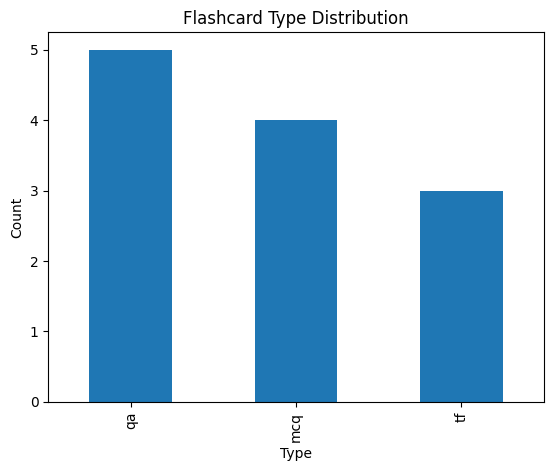

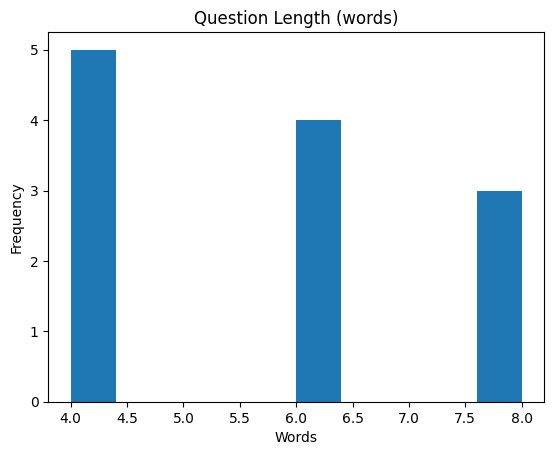

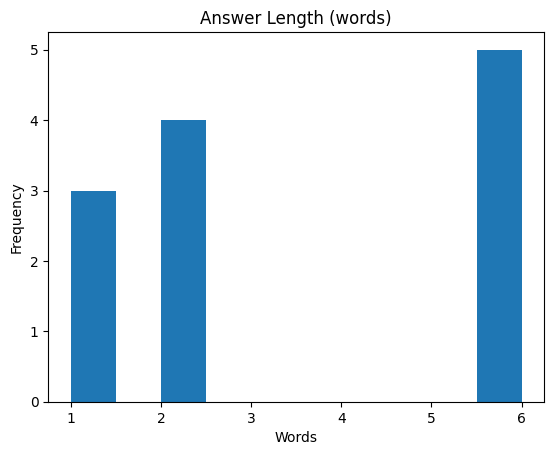

In [26]:
# 12: Analytics (plots + stats)
import matplotlib.pyplot as plt
import numpy as np

def deck_stats(deck):
    df = pd.DataFrame(deck)
    counts_type = df['type'].value_counts().to_dict()
    q_len = df['question'].apply(lambda s: len(str(s).split()))
    a_len = df['answer'].apply(lambda s: len(str(s).split()))
    return {
        "count": len(deck),
        "by_type": counts_type,
        "avg_q_words": float(q_len.mean()),
        "avg_a_words": float(a_len.mean())
    }

def plot_distribution(deck):
    df = pd.DataFrame(deck)
    # Type distribution
    plt.figure()
    df['type'].value_counts().plot(kind='bar', title='Flashcard Type Distribution')
    plt.xlabel('Type'); plt.ylabel('Count')
    plt.show()

    # Question length histogram
    plt.figure()
    df['question'].apply(lambda s: len(str(s).split())).plot(kind='hist', bins=10, title='Question Length (words)')
    plt.xlabel('Words'); plt.ylabel('Frequency')
    plt.show()

    # Answer length histogram
    plt.figure()
    df['answer'].apply(lambda s: len(str(s).split())).plot(kind='hist', bins=10, title='Answer Length (words)')
    plt.xlabel('Words'); plt.ylabel('Frequency')
    plt.show()

# Example: run analytics on your latest deck (e.g., deck2 or the one from Cell 9)
_which = 'deck2' if 'deck2' in globals() else None
if _which:
    print("Stats:", deck_stats(deck2))
    plot_distribution(deck2)
else:
    print("No deck named 'deck2' found. Run Cell 8b or 9 first, or call deck_stats(your_deck).")


In [27]:
# 13: Spaced Repetition (SM-2-like)
import time
from datetime import datetime, timedelta

# In-memory SRS store: card_id -> schedule
SRS = {}

def _card_id(card):
    # Use question text as an id scaffold (ok for demo)
    return str(abs(hash(card.get("type","") + "|" + card.get("question",""))))

def srs_init_deck(deck):
    now = datetime.utcnow()
    for c in deck:
        cid = _card_id(c)
        if cid not in SRS:
            SRS[cid] = {"easiness": 2.5, "interval_days": 0, "repetitions": 0, "due": now}

def srs_update(cid, quality):
    # quality: 0..5 (3+ counts as correct)
    d = SRS[cid]
    q = max(0, min(5, int(quality)))
    if q >= 3:
        d["repetitions"] += 1
        if d["repetitions"] == 1:
            d["interval_days"] = 1
        elif d["repetitions"] == 2:
            d["interval_days"] = 6
        else:
            d["interval_days"] = int(round(d["interval_days"] * d["easiness"]))
    else:
        d["repetitions"] = 0
        d["interval_days"] = 1
    d["easiness"] = max(1.3, d["easiness"] + (0.1 - (5 - q) * (0.08 + (5 - q) * 0.02)))
    d["due"] = datetime.utcnow() + timedelta(days=d["interval_days"])

def srs_due(deck, limit=10):
    # Return due cards sorted by earliest due
    now = datetime.utcnow()
    items = []
    for c in deck:
        cid = _card_id(c)
        if cid not in SRS: continue
        if SRS[cid]["due"] <= now:
            items.append((SRS[cid]["due"], c))
    items.sort(key=lambda x: x[0])
    return [c for _, c in items[:limit]]

# Demo on deck2 if present
if 'deck2' in globals():
    srs_init_deck(deck2)
    due = srs_due(deck2, limit=5)
    print(f"Due now: {len(due)} cards")
    if due:
        # simulate grading first due card
        first = due[0]
        cid = _card_id(first)
        srs_update(cid, quality=4)
        print("Updated SRS for 1 card; next due:", SRS[cid]["due"])
else:
    print("Run Cell 8b or 9 to create a deck, then re-run this cell.")


Due now: 5 cards
Updated SRS for 1 card; next due: 2025-09-25 01:52:34.461276


/tmp/ipython-input-2577139613.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()
/tmp/ipython-input-2577139613.py:39: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()
/tmp/ipython-input-2577139613.py:35: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  d["due"] = datetime.utcnow() + timedelta(days=d["interval_days"])


In [28]:
# 14: DOCX Export
!pip -q install python-docx
from docx import Document
from docx.shared import Pt
from pathlib import Path

def export_docx(deck, fname="flashcards.docx"):
    Path("flashcards_exports").mkdir(exist_ok=True)
    path = Path("flashcards_exports") / fname
    doc = Document()
    doc.add_heading("AI Flashcards", level=1)
    for i, c in enumerate(deck, 1):
        doc.add_heading(f"{i}. [{c.get('type','QA').upper()}]", level=2)
        doc.add_paragraph(f"Q: {c.get('question','')}")
        if c.get("type") == "mcq" and c.get("options"):
            for j, opt in enumerate(c["options"]):
                doc.add_paragraph(f"{chr(65+j)}. {opt}")
        doc.add_paragraph(f"A: {c.get('answer','')}")
        if c.get("explanation"):
            p = doc.add_paragraph("Why: " + c["explanation"])
    doc.save(str(path))
    return str(path)

# Example:
if 'deck2' in globals():
    p = export_docx(deck2, "neural_networks_flashcards.docx")
    print("Saved:", p)
else:
    print("No deck2 found; export_docx(deck, 'name.docx') with your deck.")


Saved: flashcards_exports/neural_networks_flashcards.docx


In [34]:
# speed-optimized generator + batch creation
!pip -q install transformers sentencepiece

import re, json, os, pandas as pd
from transformers import pipeline

# 1) Load a smaller model on GPU if available
MODEL_NAME = "google/flan-t5-base"   # try "flan-t5-small" for even faster
DEVICE = 0 if os.environ.get("COLAB_GPU") or os.path.exists("/proc/driver/nvidia/version") else -1

fast_gen = pipeline(
    "text2text-generation",
    model=MODEL_NAME,
    device=DEVICE,
)

def _fast_call(prompt, max_new_tokens=96):
    out = fast_gen(
        prompt,
        max_new_tokens=max_new_tokens,
        do_sample=False,          # deterministic & faster
        temperature=0.01,
        num_return_sequences=1,
        truncation=True,
    )[0]["generated_text"]
    return out.strip()

# --- Batch builders (1 call per type) ---
def fast_generate_qa_batch(topic, n=6):
    prompt = (
        f"Create {n} concise Q&A study flashcards about '{topic}'. "
        "Return JSON ONLY of the form:\n"
        "{ \"cards\": [ {\"type\":\"qa\",\"question\":\"...\",\"answer\":\"...\"}, ... ] }"
    )
    text = _fast_call(prompt)
    m = re.search(r"\{.*\}\s*$", text, flags=re.S)
    js = json.loads(m.group(0)) if m else {"cards":[]}
    cards = []
    for it in js.get("cards", [])[:n]:
        q = it.get("question","").strip()
        a = it.get("answer","").strip()
        if q and a:
            cards.append({"type":"qa","question":q,"answer":a})
    # Fallback if parse failed
    while len(cards) < n:
        i = len(cards)+1
        cards.append({"type":"qa","question":f"What is {topic} ({i})?","answer":f"Brief explanation of {topic}."})
    return cards

def fast_generate_mcq_batch(topic, n=4):
    prompt = (
        f"Create {n} 4-option MCQs about '{topic}'. Medium difficulty. "
        "Return JSON ONLY:\n"
        "{ \"cards\": [ {\"type\":\"mcq\",\"question\":\"...\",\"options\":[\"A\",\"B\",\"C\",\"D\"],"
        "\"answer\":\"A|B|C|D\",\"explanation\":\"...\"}, ... ] }"
    )
    text = _fast_call(prompt)
    m = re.search(r"\{.*\}\s*$", text, flags=re.S)
    js = json.loads(m.group(0)) if m else {"cards":[]}
    cards = []
    for it in js.get("cards", [])[:n]:
        q = it.get("question","").strip()
        opts = it.get("options", [])
        ans = (it.get("answer","") or "").strip()
        exp = (it.get("explanation","") or "").strip()
        if q and isinstance(opts, list) and len(opts) == 4 and ans in ["A","B","C","D"]:
            idx = "ABCD".index(ans)
            cards.append({
                "type":"mcq",
                "question":q,
                "options":opts,
                "answer":opts[idx],
                "answer_letter":ans,
                "explanation":exp
            })
    while len(cards) < n:
        cards.append({
            "type":"mcq",
            "question": f"Which option best describes {topic}?",
            "options": ["Definition", "Unrelated term", "Dataset", "File format"],
            "answer": "Definition",
            "answer_letter": "A",
            "explanation": "Definition matches the concept."
        })
    return cards

def fast_generate_tf_batch(topic, n=3):
    prompt = (
        f"Create {n} True/False flashcards about '{topic}'. "
        "Return JSON ONLY:\n"
        "{ \"cards\": [ {\"type\":\"tf\",\"statement\":\"...\",\"answer\":\"True|False\",\"explanation\":\"...\"}, ... ] }"
    )
    text = _fast_call(prompt)
    m = re.search(r"\{.*\}\s*$", text, flags=re.S)
    js = json.loads(m.group(0)) if m else {"cards":[]}
    cards = []
    for it in js.get("cards", [])[:n]:
        s = it.get("statement","").strip()
        ans = (it.get("answer","True") or "True").strip().title()
        exp = (it.get("explanation","") or "").strip()
        if s and ans in ["True","False"]:
            cards.append({"type":"tf","question":s,"answer":ans,"explanation":exp})
    while len(cards) < n:
        cards.append({"type":"tf","question":f"{topic} is used in machine learning.", "answer":"True", "explanation":"General fact."})
    return cards

def fast_generate_deck(topic, n_qa=4, n_mcq=4, n_tf=3):
    deck = []
    if n_qa:  deck += fast_generate_qa_batch(topic, n_qa)
    if n_mcq: deck += fast_generate_mcq_batch(topic, n_mcq)
    if n_tf:  deck += fast_generate_tf_batch(topic, n_tf)
    return deck

print("✅ FAST MODE ready. Model:", MODEL_NAME, "| device:", "GPU" if DEVICE==0 else "CPU")


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


✅ FAST MODE ready. Model: google/flan-t5-base | device: CPU


In [35]:
# 15: Mini UI with Gradio
!pip -q install gradio==4.44.0

import gradio as gr

def ui_generate(topic, n_qa, n_mcq, n_tf):
    deck = generate_deck(topic, n_qa=int(n_qa), n_mcq=int(n_mcq), n_tf=int(n_tf))
    df = pd.DataFrame(deck)
    # quick export paths
    prefix = re.sub(r"[^a-z0-9]+","_", topic.lower()).strip("_")
    csv_path  = export_csv(deck,  f"{prefix}.csv")
    tsv_path  = export_anki_tsv(deck, f"{prefix}_anki.tsv")
    json_path = export_json(deck, f"{prefix}.json")
    head = df.head(10).to_markdown(index=False)
    report = f"### Generated {len(deck)} cards for **{topic}**\n\n" \
             f"- CSV: `{csv_path}`\n- TSV: `{tsv_path}`\n- JSON: `{json_path}`\n\n" \
             f"**Preview (first 10):**\n\n{head}"
    return report

with gr.Blocks(title="AI Flashcard Maker") as demo:
    gr.Markdown("# 📚 AI Flashcard Maker (No OpenAI Key)")
    topic = gr.Textbox(label="Topic", value="Decision Trees")
    n_qa  = gr.Slider(0, 20, value=6, step=1, label="Q&A cards")
    n_mcq = gr.Slider(0, 20, value=5, step=1, label="MCQ cards")
    n_tf  = gr.Slider(0, 20, value=4, step=1, label="True/False cards")
    btn   = gr.Button("Generate Deck")
    out   = gr.Markdown()
    btn.click(ui_generate, inputs=[topic, n_qa, n_mcq, n_tf], outputs=out)

demo.launch(share=True)



/usr/local/lib/python3.12/dist-packages/gradio/analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://11e08e8192127c113e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
